Change our model to use a 5 × 5 kernel with kernel_size=5 passed to the nn.Conv2d constructor. <br>
a What impact does this change have on the number of parameters in the model?<br>
b Does the change improve or degrade overfitting?<br>
c Read https://pytorch.org/docs/stable/nn.html#conv2d.<br>
d Can you describe what kernel_size=(1,3) will do?<br>
e How does the model behave with such a kernel?<br>

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [00:02<00:00, 60942676.11it/s]


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [ ]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Model

The formula given for calculating the output size (one dimension) of a convolution is (W−F+2P)/S+1

If you want to keep the output size same as the input size, you can equate (W−max(F,S)+2P)/S+1=W
Solving this, when S=1
 gives:

W−F+2P+1=W

2P=F−1

When S>1
, you could solve the amount of padding needed to keep the output size same as the input size:

2P=max(F,S)−S

https://stats.stackexchange.com/questions/297678/how-to-calculate-optimal-zero-padding-for-convolutional-neural-networks

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Number of Parameters

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(20906, [1200, 16, 3200, 8, 16384, 32, 64, 2])

Training Loop

In [ ]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>

            outputs = model(imgs)  # <4>

            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>

            loss.backward()  # <7>

            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

We use the Dataset from chapter 7; wrap it into a DataLoader; instantiate our network, an optimizer, and a loss function as before; and call our training loop.
 The substantial changes in our model from the last chapter are that now our
model is a custom subclass of nn.Module and that we’re using convolutions. Let’s run
training for 100 epochs while printing the loss. Depending on your hardware, this
may take 20 minutes or more to finish!

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-04-26 17:51:44.178096 Epoch 1, Training loss 0.5639230434302311
2024-04-26 17:52:37.200346 Epoch 10, Training loss 0.3269234761880462
2024-04-26 17:53:35.923911 Epoch 20, Training loss 0.2844390675520441
2024-04-26 17:54:34.117760 Epoch 30, Training loss 0.2556565905072887
2024-04-26 17:55:33.628358 Epoch 40, Training loss 0.2317938423555368
2024-04-26 17:56:31.910825 Epoch 50, Training loss 0.2051310299118613
2024-04-26 17:57:30.688470 Epoch 60, Training loss 0.18354635097228797
2024-04-26 17:58:29.351167 Epoch 70, Training loss 0.1645348866464226
2024-04-26 17:59:28.720147 Epoch 80, Training loss 0.14300961151814004
2024-04-26 18:00:27.506357 Epoch 90, Training loss 0.12541566530515433
2024-04-26 18:01:26.332072 Epoch 100, Training loss 0.10656613130478343


Checking Training and Validation Loss to see the amount of overfitting

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.96
Accuracy val: 0.89


Kernel_size can be a tuple of two ints – in which case, the first int is used for the height dimension, and the second int for the width dimension

There is a slight increase in the training accuracy but no change in Validation accuracy when we change filter size from 3x3 to 5x5

With Kernel size (1,3) using padding = 'same' which pads the input so the output has the shape as the input. However, this mode doesn’t support any stride values other than 1.

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(1,3), padding='same')
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(1,3), padding='same')
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(17034, [144, 16, 384, 8, 16384, 32, 64, 2])

In [ ]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>

            outputs = model(imgs)  # <4>

            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>

            loss.backward()  # <7>

            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-04-26 21:26:11.400002 Epoch 1, Training loss 0.5659798695023652
2024-04-26 21:26:50.290938 Epoch 10, Training loss 0.34299551254245125
2024-04-26 21:27:31.790345 Epoch 20, Training loss 0.3158297742817812
2024-04-26 21:28:13.024979 Epoch 30, Training loss 0.2944501834880015
2024-04-26 21:28:55.054121 Epoch 40, Training loss 0.27680306620658585
2024-04-26 21:29:36.148278 Epoch 50, Training loss 0.2629637216116972
2024-04-26 21:30:17.983434 Epoch 60, Training loss 0.24467909226941456
2024-04-26 21:30:58.740232 Epoch 70, Training loss 0.23126557146667676
2024-04-26 21:31:40.665242 Epoch 80, Training loss 0.21842472611149405
2024-04-26 21:32:22.553775 Epoch 90, Training loss 0.20714929903958254
2024-04-26 21:33:04.600887 Epoch 100, Training loss 0.19390393776973341


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.89


Chap 10 Deep Learning with Python

Experiment 1: Load and prepare the weather data and implement the model described in
Listing 10.23 (two GRU layers). <br>
Replace the model-check-point callback with an early-stopping callback;  <br>
set the restore_best_weights parameter to True and the patience parameter to 5.  <br>
Monitor the validation MAE.

In [16]:
#loading and preparing the weather data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-27 20:50:01--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.147.37, 52.217.136.184, 54.231.230.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.147.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  44.8MB/s    in 0.3s    

2024-04-27 20:50:02 (44.8 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Inspecting the data of the Jena weather dataset

In [17]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing the data

In [18]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

#### Preparing the data

Computing the number of samples we'll use for each data split

In [19]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalizing the data

In [20]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating datasets for training, validation, and testing

In [21]:
import numpy as np
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Computing the common-sense baseline MAE

In [22]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### Stacking recurrent layers


**Training and evaluating a dropout-regularized, stacked GRU model**<br>
**Experiment 1**<br>
Replace the model-check-point callback with an early-stopping callback; set the restore_best_weights parameter to True and the patience
parameter to 5. Monitor the validation MAE.

EarlyStopping : Stop training when a monitored metric has stopped improving.<br>
<br> Test_mae value greater than the original GRU model after changing to early stopping. Original GRU model has 2.39 as test_mae value

In [ ]:
import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.EarlyStopping( monitor="val_mae",patience=5,restore_best_weights=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 187s 225ms/step - loss: 28.2655 - mae: 3.9035 - val_loss: 9.2553 - val_mae: 2.3457
Epoch 2/50
819/819 [==============================] - 191s 233ms/step - loss: 14.0323 - mae: 2.9054 - val_loss: 9.2471 - val_mae: 2.3594
Epoch 3/50
819/819 [==============================] - 189s 231ms/step - loss: 13.2106 - mae: 2.8194 - val_loss: 9.3891 - val_mae: 2.3792
Epoch 4/50
819/819 [==============================] - 189s 230ms/step - loss: 12.7239 - mae: 2.7673 - val_loss: 9.0997 - val_mae: 2.3381
Epoch 5/50
819/819 [==============================] - 187s 229ms/step - loss: 12.1535 - mae: 2.7027 - val_loss: 8.8078 - val_mae: 2.3117
Epoch 6/50
819/819 [==============================] - 189s 231ms/step - loss: 11.7367 - mae: 2.6605 - val_loss: 9.4152 - val_mae: 2.3940
Epoch 7/50
819/819 [==============================] - 187s 229ms/step - loss: 11.4010 - mae: 2.6232 - val_loss: 8.9971 - val_mae: 2.3470
Epoch 8/50
819/819 [=====================


Experiment 2: Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout

units: Positive integer, dimensionality of the output space.<br>
units changed to 16 and recurrent_dropout and dropout changed to 0.3<br>
Observation: Test_mae value greater than the original GRU model and no significant change from Experiment 1.<br>


In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 159s 189ms/step - loss: 39.8764 - mae: 4.6351 - val_loss: 12.2673 - val_mae: 2.6216
Epoch 2/50
819/819 [==============================] - 139s 169ms/step - loss: 14.3318 - mae: 2.9289 - val_loss: 9.1999 - val_mae: 2.3433
Epoch 3/50
819/819 [==============================] - 139s 170ms/step - loss: 13.0486 - mae: 2.8040 - val_loss: 9.0523 - val_mae: 2.3318
Epoch 4/50
819/819 [==============================] - 140s 171ms/step - loss: 12.5551 - mae: 2.7477 - val_loss: 8.9762 - val_mae: 2.3191
Epoch 5/50
819/819 [==============================] - 144s 175ms/step - loss: 12.1766 - mae: 2.7072 - val_loss: 9.0265 - val_mae: 2.3324
Epoch 6/50
819/819 [==============================] - 148s 181ms/step - loss: 11.8159 - mae: 2.6697 - val_loss: 8.6915 - val_mae: 2.2958
Epoch 7/50
819/819 [==============================] - 146s 178ms/step - loss: 11.5321 - mae: 2.6405 - val_loss: 8.9875 - val_mae: 2.3314
Epoch 8/50
819/819 [====================

 Experiment 3: Adjust the learning rate used by the RMSprop optimizer, or try a
different optimizer, e.g., Adam.

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 154s 183ms/step - loss: 46.2343 - mae: 4.9966 - val_loss: 18.6787 - val_mae: 3.1482
Epoch 2/50
819/819 [==============================] - 153s 186ms/step - loss: 17.4435 - mae: 3.1564 - val_loss: 11.6887 - val_mae: 2.5635
Epoch 3/50
819/819 [==============================] - 153s 187ms/step - loss: 14.3600 - mae: 2.9117 - val_loss: 10.3212 - val_mae: 2.4500
Epoch 4/50
819/819 [==============================] - 152s 185ms/step - loss: 13.3287 - mae: 2.8201 - val_loss: 9.8207 - val_mae: 2.4097
Epoch 5/50
819/819 [==============================] - 153s 187ms/step - loss: 12.7641 - mae: 2.7632 - val_loss: 9.5004 - val_mae: 2.3844
Epoch 6/50
819/819 [==============================] - 152s 185ms/step - loss: 12.4051 - mae: 2.7269 - val_loss: 9.8322 - val_mae: 2.4328
Epoch 7/50
819/819 [==============================] - 149s 182ms/step - loss: 12.0690 - mae: 2.6920 - val_loss: 9.2135 - val_mae: 2.3590
Epoch 8/50
819/819 [==================

####  Experiment 4: Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(8)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.EarlyStopping( monitor="val_mae",patience=5,restore_best_weights=True)
]
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
819/819 [==============================] - 204s 241ms/step - loss: 44.9574 - mae: 5.0454 - val_loss: 12.8786 - val_mae: 2.7985
Epoch 2/25
819/819 [==============================] - 195s 237ms/step - loss: 33.4972 - mae: 4.3675 - val_loss: 13.1244 - val_mae: 2.8335
Epoch 3/25
819/819 [==============================] - 195s 238ms/step - loss: 30.6107 - mae: 4.1887 - val_loss: 12.0087 - val_mae: 2.7181
Epoch 4/25
819/819 [==============================] - 190s 232ms/step - loss: 28.9354 - mae: 4.0811 - val_loss: 11.0847 - val_mae: 2.5975
Epoch 5/25
819/819 [==============================] - 185s 226ms/step - loss: 27.5296 - mae: 3.9826 - val_loss: 11.6425 - val_mae: 2.6663
Epoch 6/25
819/819 [==============================] - 187s 228ms/step - loss: 26.4273 - mae: 3.9021 - val_loss: 10.8786 - val_mae: 2.5678
Epoch 7/25
819/819 [==============================] - 190s 231ms/step - loss: 25.5345 - mae: 3.8341 - val_loss: 10.6083 - val_mae: 2.5346
Epoch 8/25
819/819 [==============

#### Representation as Pandas Dataframe and Bar Chart

In [5]:
import pandas as pd

# Data
test_mae = [2.62, 2.39, 2.47, 2.45, 2.48, 2.74]
val_mae = [2.44, 2.36, 2.48, 2.69, 2.63, 2.53]
index = ['Baseline', 'Original_GRU', 'Expt1', 'Expt2', 'Expt3', 'Expt4']

# Create DataFrame
df = pd.DataFrame({'test_mae': test_mae, 'val_mae': val_mae}, index=index)

# Display DataFrame
print(df)

              test_mae  val_mae
Baseline          2.62     2.44
Original_GRU      2.39     2.36
Expt1             2.47     2.48
Expt2             2.45     2.69
Expt3             2.48     2.63
Expt4             2.74     2.53


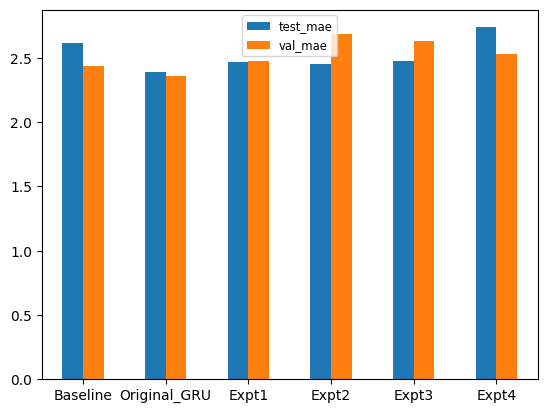

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
test_mae= [2.62, 2.39, 2.47, 2.45, 2.48, 2.74]
val_mae = [2.44, 2.36, 2.48, 2.69, 2.63, 2.53]
index = ['Baseline','Original_GRU', 'Expt1', 'Expt2','Expt3', 'Expt4']
df = pd.DataFrame({'test_mae': test_mae, 'val_mae': val_mae }, index=index)
ax = df.plot.bar(rot=0)
plt.legend(fontsize='small',loc='upper center')
plt.show()

#### Comprehensive Conclusion: <br>
<br>
The common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if we always assume that the temperature 24 hours in the future will be the same as it is now, we will be off by two and a half degrees on average.<br>
<br>
The Original GRU model achieves a test_mae of 2.39 degrees which is 8.8% improvement over the baseline<br>
<br>
Experiment 1 model achieves a test_mae of 2.47 degrees which is 5.7% improvement over the baseline<br>
<br>
Experiment 2 model achieves a test_mae of 2.45 degrees which is 6.5% improvement over the baseline<br>
<br>
Experiment 3 model achieves a test_mae of 2.48 degrees which is 5.3% improvement over the baseline<br>
<br>
Experiment 4 model achieves a test_mae of 2.74 degrees which is 4.6%
degradation from the baseline<br>

<br>
Therefore, Original GRU model with two recurrent layers and one dense layer achieves the best performance out of the other four models.